In [4]:
# 如下为《统计学习方法》的关于建立模型的基本要素

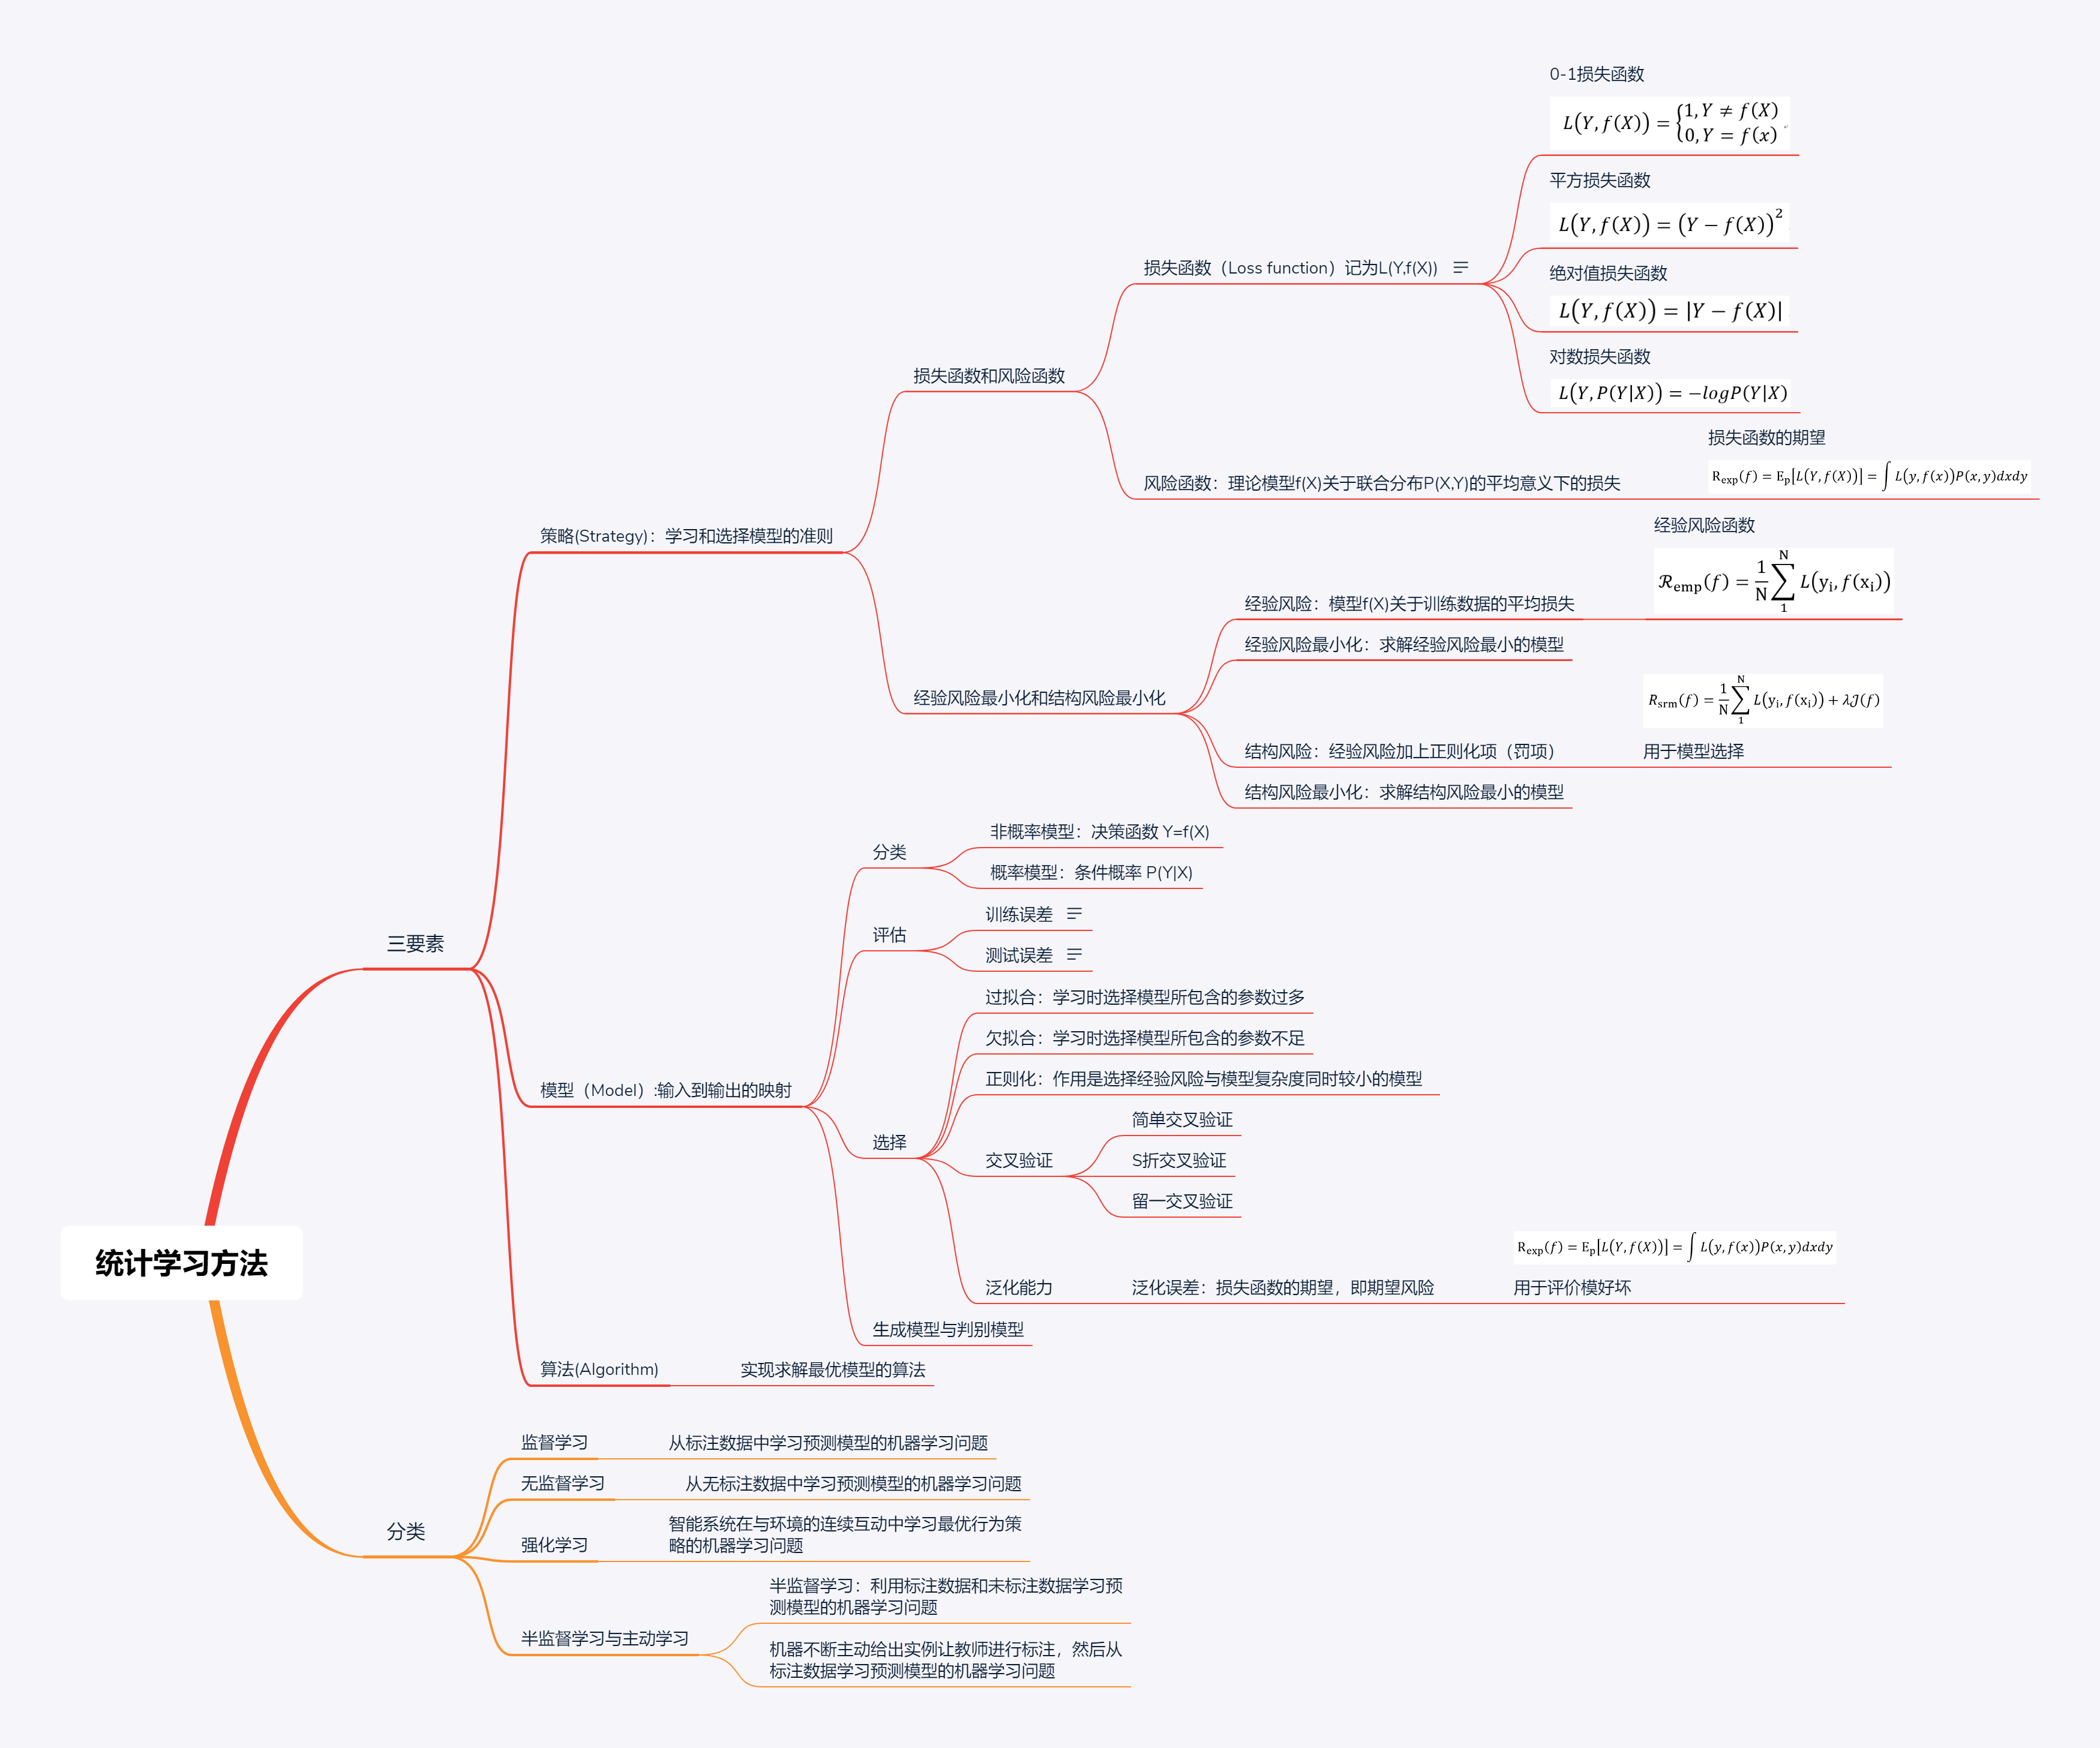

# 线性回归
主要内容包括：

1. 线性回归的基本要素
2. 线性回归模型从零开始的实现
3. 线性回归模型使用pytorch的简洁实现

## 线性回归的基本要素

### 模型
为了简单起见，这里我们假设价格只取决于房屋状况的两个因素，即面积（平方米）和房龄（年）。接下来我们希望探索价格与这两个因素的具体关系。线性回归假设输出与各个输入之间是线性关系:


$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



### 数据集
我们通常收集一系列的真实数据，例如多栋房屋的真实售出价格和它们对应的面积和房龄。我们希望在这个数据上面寻找模型参数来使模型的预测价格与真实价格的误差最小。在机器学习术语里，该数据集被称为训练数据集（training data set）或训练集（training set），一栋房屋被称为一个样本（sample），其真实售出价格叫作标签（label），用来预测标签的两个因素叫作特征（feature）。特征用来表征样本的特点。
### 损失函数
在模型训练中，我们需要衡量价格预测值与真实值之间的误差。通常我们会选取一个非负数作为误差，且数值越小表示误差越小。一个常用的选择是平方函数。 它在评估索引为 $i$ 的样本误差的表达式为


$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$



$$
L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.
$$


### 优化函数 - 随机梯度下降
当模型和损失函数形式较为简单时，上面的误差最小化问题的解可以直接用公式表达出来。这类解叫作解析解（analytical solution）。本节使用的线性回归和平方误差刚好属于这个范畴。然而，大多数深度学习模型并没有解析解，只能通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。这类解叫作数值解（numerical solution）。

在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）$\mathcal{B}$，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。   

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  
学习率: $\eta$代表在每次优化中，能够学习的步长的大小    
批量大小: $\mathcal{B}$是小批量计算中的批量大小batch size   

总结一下，优化函数的有以下两个步骤：

- (i)初始化模型参数，一般来说使用随机初始化；
- (ii)我们在数据上迭代多次，通过在负梯度方向移动参数来更新每个参数。

## 矢量计算
在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。


1. 向量相加的一种方法是，将这两个向量按元素逐一做标量加法。
2. 向量相加的另一种方法是，将这两个向量直接做矢量加法。

In [1]:
import torch
import time

# init variable a, b as 1000 dimension vector
n = 1000
a = torch.ones(n)
b = torch.ones(n)


In [2]:
# define a timer class to record time
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

现在我们可以来测试了。首先将两个向量使用for循环按元素逐一做标量加法。

In [3]:
# 标量加法
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop()

'0.01233 sec'

另外是使用torch来将两个向量直接做矢量加法：

In [4]:
# 矢量加法
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00022 sec'

结果很明显,后者比前者运算速度更快。因此，我们应该尽可能采用矢量计算，以提升计算效率。

## 线性回归模型从零开始的实现



In [5]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.3.0


### 生成数据集
使用线性模型来生成数据集，生成一个1000个样本的数据集，下面是用来生成数据的线性关系：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [6]:
# set input feature number 
num_inputs = 2
# set example number
num_examples = 1000

# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
# 生成数据
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 加一个随机变量，正态分布
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

### 使用图像来展示生成的数据

In [7]:
def use_svg_display():
    # display in vector graph
    display.set_matplotlib_formats('svg')

def set_figsize(figsize = (3.5, 2.5)):
    # set the size of figure
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

<Figure size 432x288 with 1 Axes>

### 读取数据集

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [9]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.7331, -0.7229],
        [ 1.1899, -0.8475],
        [-0.7291,  0.3154],
        [ 1.8339,  0.6775],
        [-1.2193, -1.4764],
        [-0.2043, -0.4641],
        [-0.2074, -1.4161],
        [ 0.4510,  0.2290],
        [ 0.1711, -0.2138],
        [ 0.2404, -1.3124]]) 
 tensor([5.1748, 9.4611, 1.6620, 5.5723, 6.7934, 5.3762, 8.5957, 4.3282, 5.2609,
        9.1437])


### 初始化模型参数

In [10]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 定义模型
定义用来训练参数的训练模型：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [11]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

### 定义损失函数
我们使用的是均方误差损失函数：
$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$


In [12]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 定义优化函数
在这里优化函数使用的是小批量随机梯度下降：

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  

In [13]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track

### 训练
当数据集、模型、损失函数和优化函数定义完了之后就可来准备进行模型的训练了。


In [14]:
# super parameters init
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        # 计算每个小批次的损失函数
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 计算反向传播
        l.backward()  
        # using small batch random gradient descent to iter model parameters更新梯度
        # 更新梯度
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient 在grad更新时，每一次运算后都需要将上一次的梯度记录清空

        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.031161
epoch 2, loss 0.000109
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000051


In [15]:
w, true_w, b, true_b

(tensor([[ 1.9997],
         [-3.3999]], requires_grad=True),
 [2, -3.4],
 tensor([4.1997], requires_grad=True),
 4.2)

## 线性回归模型使用pytorch的简洁实现


In [16]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.3.0


### 生成数据集
在这里生成数据集跟从零开始的实现中是完全一样的。

In [17]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

### 读取数据集

In [18]:
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=2,              # read data in multithreading
)

In [23]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[-0.8993,  0.9437],
        [ 2.9769, -0.2466],
        [-0.5232, -0.2877],
        [ 2.5673,  1.5677],
        [-0.4714,  1.6394],
        [-1.3678, -0.0244],
        [-0.2191, -0.9639],
        [ 0.8239,  0.0628],
        [-0.0412, -0.8177],
        [ 0.5538, -0.2377]]) 
 tensor([-0.8050, 10.9827,  4.1282,  3.9968, -2.3125,  1.5376,  7.0404,  5.6659,
         6.9132,  6.1181])


### 定义模型

In [19]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      # call father function to init 
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [20]:
# ways to init a multilayer network
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


### 初始化模型参数

In [21]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [22]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0152,  0.0038]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


### 定义损失函数

In [23]:
loss = nn.MSELoss()    # nn built-in squared loss function
                       # function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`

### 定义优化函数

In [24]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 训练

In [25]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000236
epoch 2, loss: 0.000079
epoch 3, loss: 0.000068


In [26]:
# result comparision
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9991, -3.4003]])
4.2 tensor([4.1997])


## 两种实现方式的比较
1. 从零开始的实现（推荐用来学习）

   能够更好的理解模型和神经网络底层的原理
   

2. 使用pytorch的简洁实现

   能够更加快速地完成模型的设计与实现
   

# 补充

1 训练集和测试集的概念及区别

1. 模型训练的过程其实就是在求【参数】的过程，我们先假定某类【模型】（比如决策树模型），然后用【训练集】来训练，学习到对应的最优的【参数】。但是问题在于，我们没有办法保证我们假设的那个【模型】是最优的，我们极有可能假设错误对吧。那怎么办呢？有一个简单的解决方案就是我们假设一堆的模型，然后用【训练集】分别对这些模型来进行训练，学习到每一个【模型】中分别对应的参数——这是第一步，也就是【训练集】的任务。

2. 那么我们已经学习到了一堆的模型了，哪一个模型是最好的呢？这其实就是要来考察不同结构的模型在这些data上的优劣程度了。通常来说，我们用【超参数】来控制模型的结构（例如正则项系数、神经网络中隐层的节点个数，k值等）。那这个时候，我们就可以找一些数据来训练和学习我们具体的超参数了。用什么样的数据呢？直接用【训练集】肯定是不行的，因为我们现在的每一个模型都是用【训练集】来学习出来的，他们在【训练集】上的效果已经很好了，继续用它们来训练超参数不会有太大的效果，所以说我们就选择了使用【验证集】来选择这些超参数。这是第二步，也就是【验证集】的任务，我们也通常称之为【调参】。

3. 最后，当我们学习到了【参数】和【非参数】后，我们就确定了我们具体的模型结构，这个时候我们再用一些数据来测试这个模型在新的数据上的效果。因此，我们就不能够使用之前已经使用过的数据了，而要选择一个全新的数据集，这既是【测试集】。这个时候我们就要来看最后的结果怎么样，如果结果很好，那么说明一切顺利，但是如果结果很差，那问题出在哪里呢？其中可能的一个原因就是我们事先假定的那一类的【模型】（比如我们最先选择的决策树模型）并不是适合来分析这些数据，因此哪怕我们选择出了这一堆决策树模型中最好的一个（超参数的选择过程），它的效果依旧不怎么样。

4. 这里还有两个遗留的问题：

   （1）训练集、验证集和测试集的比例应该怎么去进行分配呢？
   传统上是6：2：2的比例，但是不同的情况下你的选择应当不同。这方面的研究也有很多，如果你想要知道我们在设置比例的时候应当参考那些东西，可以去  看Isabelle Guyon的这篇论文：A scaling law for the validation-set training-set size ratio 。他的个人主页（http://www.clopinet.com/isabelle/）里也展示了他对于这个问题的研究。
   
   （2）训练集、验证集和测试集的数据是否可以有所重合？
   有些时候我们的数据太少了，又不想使用数据增强，那么训练集、验证集和测试集的数据是否可以有所重合呢？这方面的研究就更多了，各种交叉方法，感兴趣的话可以去看Filzmoser这一篇文章Repeated double cross validation

### 内容来自课程同学的评论，复制过来学习一下

本视频用了许多pytorch的函数，由于不是太了解pytorch内的函数，因此查询记录了一下。
torch.ones()/torch.zeros()，与MATLAB的ones/zeros很接近。初始化生成均匀分布

torch.rand(*sizes, out=None) → Tensor
返回一个张量，包含了从区间[0, 1)的均匀分布中抽取的一组随机数。张量的形状由参数sizes定义。

标准正态分布
torch.randn(*sizes, out=None) → Tensor
返回一个张量，包含了从标准正态分布（均值为0，方差为1，即高斯白噪声）中抽取的一组随机数。张量的形状由参数sizes定义。

torch.mul(a, b)是矩阵a和b对应位相乘，a和b的维度必须相等，比如a的维度是(1, 2)，b的维度是(1, 2)，返回的仍是(1, 2)的矩阵
torch.mm(a, b)是矩阵a和b矩阵相乘，比如a的维度是(1, 2)，b的维度是(2, 3)，返回的就是(1, 3)的矩阵
torch.Tensor是一种包含单一数据类型元素的多维矩阵，定义了7种CPU tensor和8种GPU tensor类型。
random.shuffle(a)：用于将一个列表中的元素打乱。shuffle() 是不能直接访问的，需要导入 random 模块，然后通过 random 静态对象调用该方法。
              
backward()是pytorch中提供的函数，配套有require_grad：
1.所有的tensor都有.requires_grad属性,可以设置这个属性.x = tensor.ones(2,4,requires_grad=True)
2.如果想改变这个属性，就调用tensor.requires_grad_()方法：　　 x.requires_grad_(False)

书籍的补充非常必要，那么针对于「线性模型」的内容，那我们就来看看「西瓜书」「统计学习方法」「ESL」「PRML」这几本书大概是怎么来讲解这部分内容的。

1. 「西瓜书」
首先我们来聊聊周志华老师的「机器学习」，也就是我们常说的「西瓜书」，是怎么来讲解线性模型的内容的。
「西瓜书」在第三章中展开了对「线性模型」的讨论，首先是介绍了线性模型的「基本形式」，无论是线性回归还是线性分类，都是基于这个基本的线性模型的形式而来。
然后，「西瓜书」介绍了在「基本形式」的基础上，如何来构建「一元线性回归」问题的目标函数，其中的关键点在于如何衡量模型输出的预测值y_hat与数据真实的真实label值y的差距。这里「西瓜书」默认使用了均方误差的距离估计指标，但是我们要知道这并不是唯一的选择。在构建好「一元线性回归」的目标函数后，我们就可以来尝试进行求解了。我们的目标是找到对应的w*和b*使得我们minE()的目标实现，而这里介绍了一种解析解的求法，也就是最小二乘法。
在介绍完一元的情况后，「西瓜书」开始介绍多元的情景，这里值得注意的是（3.10）与（3.11）之间的那个XTX的满秩假设或者正定假设通常是不成立的，因此实际上我们需要在这个地方加入正则化方法，这种方法在我们面对最优化问题的时候也非常常用。
接着，「西瓜书」开始讲解「线性分类」模型。也就是所谓的对数几率回归（log odds），通常我们也称其为logistic regression，但是要知道这与逻辑毫无关系。逻辑回归的形式其实在3.2节最后的广义线性模型那里就有了铺垫，实际上线性回归和逻辑回归在模型形式上的区别是， 
y=wTx+by = w^Tx+by=wTx+b
lny1−y=wTx+bln \frac{y}{1-y}=w^Tx+bln1−y
y​=wTx+b
可以看到就是y的形式的区别，而为什么是这样的形式，主要是和最大熵和拉格朗日乘数有关，这里就不具体介绍了。
关键在于我们在确定模型之后如何来构建对应的目标函数，这里采用了「最大似然」的思想。在目标函数确定之后，「西瓜书」又介绍了一种不同于「解析解」的「数值解」的方法。
最后「西瓜书」还介绍了线性模型的LDA的形式，他的模型和目标函数都有所不同。以及如何将而分类问题扩展到多分类的情况。最后还介绍了如何处理类别不平衡的问题。这是「西瓜书」的内容。

2. 「统计学习方法」
李航老师的「统计学学习方法」则是分别在第一张、第二章和第六章涉及到了线性模型的内容。
在第二章中，主要是对「感知机」这种线性分类模型的研究。首先依旧是先确定模型的形式，对应于「西瓜书」3.2的广义线性模型，然后在2.2.2部分讲解模型的求解策略，即如何构建目标函数。这里其实是是用了函数间隔的方法来构建目标函数。
然后就是讲解具体的学习参数的算法。首先介绍了原始形式下的随机梯度下降法（算法2.1），并且给出了算法收敛性的证明，这里可以根据例2.2来帮助理解这一算法。接着又介绍了对偶形式下的学习算法（算法2.2），可以通过例2.2来辅助理解。
第六章则涉及到了逻辑回归的问题。首先是是介绍了logistic distribution 的基本概念，以及如何使用它来构建分类模型。然后在6.1.3讲解如何是用「极大似然」的方法来构建目标函数，以及如何求参数。
6.2节则是介绍了logistic regression形式的一些由来，即关于最大熵问题的讨论，之后有机会的话给大家介绍一下如何从最大熵中推导出逻辑回归模型。6.3节则主要是介绍数值解的方法。这部分是「统计学系方法」的内容。

3. 「PRML」
「PRML」也就是我们经常说的模式识别与机器学习（Pattern Recognition and Machine Learning）这本书了，非常经典的一本贝叶斯视角的教材，李航老师的「统计学系方法」也参考了这本书的很多讲法。此外，于此对比的是「MLAPP」这本书，也是非常经典的机器学习教材，不过采用的是频率派的视角，可以与「PRML」对照着看。
「PRML」在1.5节、第三章和第四章中都有涉及到对线性模型的讨论。
其中1.5节主要是介绍了一些构建目标函数的思想，以及解决分类问题的三种方式。尽管我们一般用的比较多的还是判别式模型的方法，但是了解判别式方法和生成式模型的方法，以及它们分别的优劣势，对于我们掌握分类问题还是有很大帮助的。
第三章则是主要讲线性回归模型，与上述的两本教材不同，「PRML」在一开始就引入了「基函数」的概念（其他的教材大多是在SVM那一章节再引入），然后在基函数的概念下来构建模型。在讨论目标函数时，「PRML」对于最大似然方法和最小二乘方法之间的相互转换（看是否是高斯分布），并且给出了这两种不同方法分别如何进行求解。
而对于我们之前提到的XTX接近非满秩的情况或接近奇异矩阵的情况，「PRML」在不使用正则化的前提下提出可以使用SVD的方法来求解。当然「PRML」也没有错过对于正则化方法的介绍，这部分内容集中在3.1.4，介绍了不同的正则化项。3.1.5则主要是在处理多目标输出的情形。
3.3, 3.4 和3.5主要讲解贝叶斯下的线性回归。这一章的内容主要是为了解决如何确定合适的模型复杂度的问题。实际上最大化似然函数并不能够很好的解决这一问题，因为总会产生过于复杂的模型和过拟合现象。一种解决方式是是用独立的额外数据能够用来确定模型的复杂度（1.3节），搞定模型的超参，但是这需要较大的计算量。因此在这个地方「PRML」转而考虑线性回归的贝叶斯方法，这会避免最大似然的过拟合问题，也会引出使用训练数据本身确定模型复杂度的自动化方法。
在第四章节则是线性分类模型。依旧是二分类问题与多分类问题下的模型设置，以及最小平方方法为什么不适用于二分类问题（实际上这点在我们讲解最大似然和最小二乘的相互转化中就有提到，因为二分类问题显然不是高斯分布）。然后介绍不同的判别函数，比如Fisher判别函数和感知器的例子。
4.2主要介绍概率生成模型在分类问题上的应用，以及如何使用最大似然的方法来确定模型参数。4.3则是介绍概率判别式模型，这种方法使用了一般线性模型的函数形式，然后使用最大似然来直接确定参数（而不是从线性函数的softmax变换中取得）。4.5则是讲解贝叶斯logistic回归的内容。
这是「PRML」的部分。

4. 「ESL」
最后是「ESL」也就是统计学习基础（The Elementsof Statistical Learning）这本书。吐槽一下，这本书哪里基础了。。。
「ESL」中讲解的东西就更多了，其中比较有代表性的是它突出了L1范数的正则化方法，也就是所谓的lasso回归（L2正则化的叫岭回归）。实际上大家还可以去看看弹性网络之类的方法，综合了L1和L2，也非常有意思。

5. 然后推荐一些相关的参考资料吧，因为其实lasso回归的一些算法已经推广到广义回归模型了（最小角回归）。

其中一个经典的解法就是偏最小二乘由， Wold (1975)提出，收缩方法的比较可以在 Copas (1983)和 Frank and Friedman (1993)中找到。最小角回归过程由 Efron et al. (2004)等人提出；与这有关的是早期 Osborne et al. (2000a)和 Osborne et al. (2000b)的homotopy过程。向前逐步准则 在 Hastie et al. (2007)中进行了讨论。 Park and Hastie (2007)发展了类似用于广义回归模型的最小角回归的路径算法。


6. 一些文献：

Efron, B., Hastie, T., Johnstone, I. and Tibshirani, R. (2004). Least angle regression (with discussion), Annals of Statistics 32(2): 407–499.

Osborne, M., Presnell, B. and Turlach, B. (2000a). A new approach to variable selection in least squares problems, IMA Journal of Numerical Analysis 20: 389–404.

Osborne, M., Presnell, B. and Turlach, B. (2000b). On the lasso and its dual, Journal of Computational and Graphical Statistics 9: 319–337.

Hastie, T., Taylor, J., Tibshirani, R. and Walther, G. (2007). Forward stagewise regression and the monotone lasso, Electronic Journal of Statistics 1: 1–29.

Park, M. Y. and Hastie, T. (2007). l 1 -regularization path algorithm for generalized linear models, Journal of the Royal Statistical Society Series B 69: 659–677.

Wold, H. (1975). Soft modelling by latent variables: the nonlinear iterative partial least squares (NIPALS) approach, Perspectives in Probability and Statistics, In Honor of M. S. Bartlett, pp. 117–144.

Copas, J. B. (1983). Regression, prediction and shrinkage (with discussion), Journal of the Royal Statistical Society, Series B, Methodological 45: 311–354.

Frank, I. and Friedman, J. (1993). A statistical view of some chemometrics regression tools (with discussion), Technometrics 35(2): 109–148.

